In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
fig= plt.figure(figsize=(12,5))
plt.style.use('fivethirtyeight')

<Figure size 864x360 with 0 Axes>

In [3]:
data=pd.read_csv('avocado.csv')

In [4]:
data=data[['Date','AveragePrice','Total Volume','year','region','type']]

In [5]:
filt=(data['region']=='Houston') & (data['type']=='conventional')
data=data.loc[filt].drop(columns=['region','type'])

In [6]:
data=data.sort_values(by='Date',ascending='True')

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

<H1> Using ARIMA model to forecast quantity of demand </H1>

In [8]:
data.set_index('Date',inplace=True)

<AxesSubplot:xlabel='Date'>

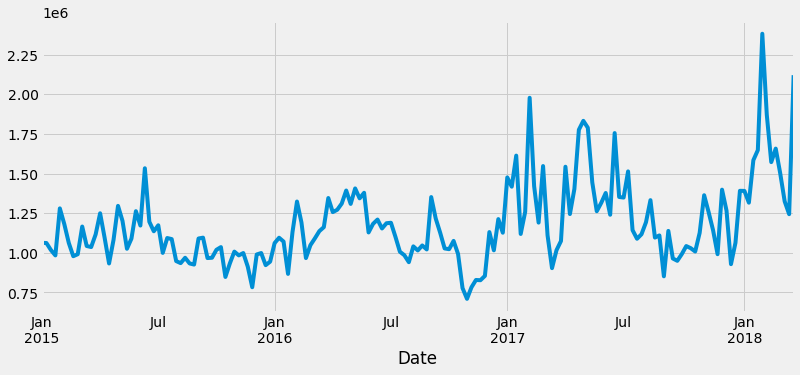

In [9]:
data['Total Volume'].plot(figsize=(12,5))

<h2> Check for seasonal decomposition </h2>

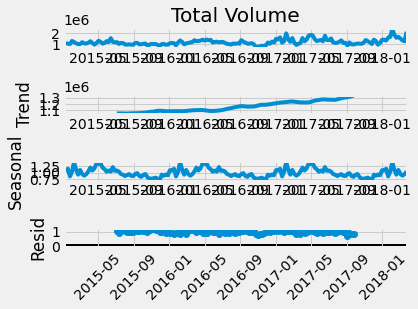

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Total Volume'],model='multiplicative')
fig=result.plot()
plt.xticks(rotation=45)
plt.show(fig)

<h2> Check for stationarity </h2>

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
adf_test(data['Total Volume'])

1. ADF :  -2.9278723763139407
2. P-Value :  0.04220150087606746
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 166
5. Critical Values :
	 1% :  -3.4703698981001665
	 5% :  -2.8791138497902193
	 10% :  -2.576139407751488


<h2> P_Value is less, so we can consider it stationary.</h2>

<h1> Using Arima model to forecast future total volumes(sales number).<h1>
<h1> Step 1: First we learn order of model </h1>
<h1> Step 2: We split data to train (first 80% data) and test (last 20%) and we train on train data; and use it to predict test data</h1>
<h1> Step 3: First we learn using whole dataset and predict sales values for future 3 months</h1>

In [12]:
from pmdarima import auto_arima
stepwise_model = auto_arima(data['Total Volume'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=3170.612, Time=8.82 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3211.134, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3172.391, Time=2.63 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=3169.457, Time=4.08 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=3185.695, Time=0.34 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=3169.596, Time=5.11 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=3169.309, Time=10.80 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=3171.303, Time=12.91 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=3188.469, Time=8.23 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=3170.205, Time=21.56 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=3171.450, Time=13.86 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=3173.219, Time=10.14 sec
 ARIMA(1,1,2)(0,1,2)[52]             : AIC=3171.752, Time=36.92 sec
 ARIMA(0,1,1)(0,1,2)[52] intercept   : AIC=3174.418, Time=11.96 sec

Best model:

<h2> Fitting ARIMA model for dataset </h2>

In [13]:
data.shape

(169, 3)

In [14]:
20/100*(data.shape[0])

33.800000000000004

In [15]:
train=data.iloc[0:-33] 
test=data.iloc[-33:]
train.shape, test.shape

((136, 3), (33, 3))

(array([16436., 16556., 16679., 16801., 16922., 17045., 17167., 17287.,
        17410., 17532., 17652.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

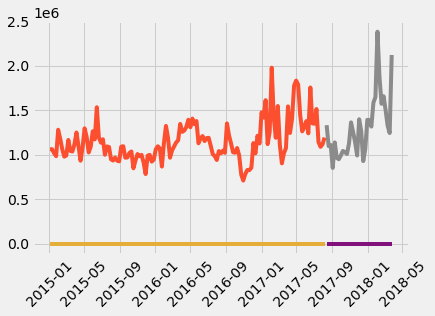

In [16]:
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)

In [17]:
forecast_model=auto_arima(train['Total Volume'],start_p=0, start_q=1,
                           max_p=0, max_q=2, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
forecast_model=forecast_model.fit(train['Total Volume'])
forecast_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2256.948, Time=3.39 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2286.727, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=2284.194, Time=2.18 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2263.342, Time=0.28 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=2258.628, Time=4.17 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=2258.626, Time=5.91 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=2256.888, Time=2.59 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=2258.626, Time=6.10 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=2260.628, Time=8.03 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=2258.896, Time=3.88 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=2259.376, Time=2.71 sec

Best model:  ARIMA(0,1,1)(1,1,0)[52]          
Total fit time: 39.439 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  136
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1125.444
Date:                             Tue, 05 Oct 2021   AIC                           2256.888
Time:                                     15:01:47   BIC                           2264.145
Sample:                                          0   HQIC                          2259.803
                                             - 136                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4540      0.100     -4.556      0.000      -0.649      -0.259
ar.S.L52      -0.3591      0.142     -2.534      0.011      -0.637      -0.081
sigma2      3.898e+10   4.57e-13   8.53e+22      0.000     3.9e+10     3.9e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 3.78
Prob(Q):                              0.65   Prob(JB):                         0.15
Heteroskedasticity (H):               3.32   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  5e+38. Standard errors may be unstable.
"""

<h2> Make predictions for test set </h2>

In [18]:
# distinguishing where train and test begins
forecast_test=forecast_model.predict(n_periods=33)
print(forecast_test)

[1172679.07198433 1179869.95937249 1161383.44785283 1431930.4917406
 1347759.49606213 1243759.2456146  1180733.82135556 1195750.22653569
 1235351.34270468 1114922.15086176 1007854.24417105  990940.81687193
 1029157.77757933 1063957.97335565 1032171.67486081 1003052.9357206
 1254247.39211146 1183854.92543567 1282648.2911308  1235433.75276393
 1501070.92731502 1475667.4401973  1592578.20473824 1202782.31855326
 1386975.66243325 1916973.30309167 1512474.65601739 1284434.06943574
 1542193.17535481 1277971.55570425 1161460.34713337 1242849.06505293
 1346029.32485385]


In [19]:
forecast_test = pd.DataFrame(forecast_test,index = test.index,columns=['Prediction'])

In [20]:
forecast_test

,Prediction
Date,
2017-08-13,1.172679e+06
2017-08-20,1.179870e+06
2017-08-27,1.161383e+06
2017-09-03,1.431930e+06
2017-09-10,1.347759e+06
2017-09-17,1.243759e+06
2017-09-24,1.180734e+06
2017-10-01,1.195750e+06
2017-10-08,1.235351e+06


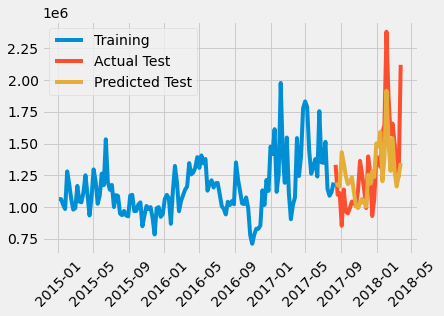

In [21]:
plt.plot(train['Total Volume'],label='Training')
plt.plot(test['Total Volume'],label='Actual Test')
plt.plot(forecast_test,label='Predicted Test')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('ARIMA_train-test-prediction.png')
plt.show()


In [22]:
test['Total Volume'].mean()

1304725.0012121215

In [23]:
def rmse(actual,predict):
    return sqrt(mean_squared_error(actual,predict))

In [24]:
rmse(test['Total Volume'],forecast_test['Prediction'])

270834.5461140232

<h2> To make predictions on next 3 months </H2>

In [25]:
data.tail()

,AveragePrice,Total Volume,year
Date,,,
2018-02-25,0.67,1657524.28,2018
2018-03-04,0.71,1501699.41,2018
2018-03-11,0.83,1324475.69,2018
2018-03-18,0.79,1243926.96,2018
2018-03-25,0.56,2120511.03,2018


In [26]:
future_model=forecast_model.fit(data['Total Volume'])
index_future_dates=pd.date_range(start='2018-03-25', end='2018-06-25')
pred_future=future_model.predict(n_periods=93)


In [27]:
future_volumes = pd.DataFrame(pred_future,index = index_future_dates,columns=['Forecasting'])

In [28]:
future_volumes

,Forecasting
2018-03-25,2.001255e+06
2018-03-26,1.857184e+06
2018-03-27,1.956634e+06
2018-03-28,2.186617e+06
2018-03-29,2.173553e+06
...,...
2018-06-21,2.106937e+06
2018-06-22,1.902912e+06
2018-06-23,1.982405e+06
2018-06-24,2.315474e+06


In [29]:
future_volumes.to_csv ('Future_Forecasted_Sales.csv', index = False, header=True)

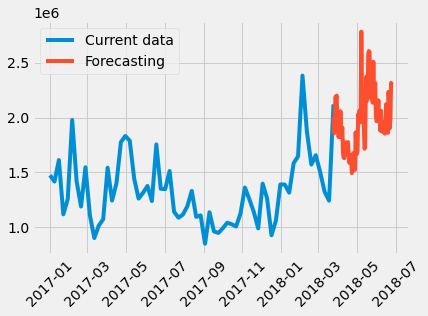

In [30]:
st_date=pd.to_datetime('2017-01-01')
plt.plot(data.loc[st_date:,'Total Volume'],label='Current data')
plt.plot(future_volumes['Forecasting'],label='Forecasting')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('ARIMA_NEXT3MONTHS_SALES_PREDICTION.png')
plt.show()